In [1]:
import pandas as pd
import psycopg2
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
]

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host='localhost',
    user='postgres',
    password='man12345',
    dbname='mydb'  # use dbname instead of database
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/manth/OneDrive/Desktop/E-Commerce'

# Function to map pandas dtypes to PostgreSQL types
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INTEGER'
    elif pd.api.types.is_float_dtype(dtype):
        return 'REAL'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'TIMESTAMP'
    else:
        return 'TEXT'

# Process each CSV file
for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULLs
    df = df.where(pd.notnull(df), None)

    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names for compatibility
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Create table with appropriate data types
    columns = ', '.join([f'"{col}" {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS "{table_name}" ({columns})'
    cursor.execute(create_table_query)

    # Prepare INSERT statement
    column_names = ', '.join([f'"{col}"' for col in df.columns])
    placeholders = ', '.join(['%s'] * len(df.columns))
    insert_query = f'INSERT INTO "{table_name}" ({column_names}) VALUES ({placeholders})'

    # Insert data row by row
    for _, row in df.iterrows():
        values = tuple(None if pd.isna(x) else x for x in row)
        cursor.execute(insert_query, values)

    # Commit after each table
    conn.commit()

# Close the connection
conn.close()


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [ ]:
pip install psycopg2-binary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2

db = psycopg2.connect(
    host='localhost',
    user='postgres',
    password='man12345',
    dbname='mydb'  
)
cur  = db.cursor()

# List All unique cities where customers are located

In [13]:
query = """select customer_city from customers"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data).head(10)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,sao paulo
7,timoteo
8,curitiba
9,belo horizonte


# Count the number of orders palced in 2017

In [7]:
db.rollback()
query = """
SELECT COUNT(order_id)
FROM orders
WHERE EXTRACT(YEAR FROM order_purchase_timestamp::timestamp) = 2017
"""
cur.execute(query)
data = cur.fetchall()
"total order palced in 2017 are:",data[0][0]



('total order palced in 2017 are:', 180404)

# Find total sales  per category 

In [40]:
db.rollback()
query = """
SELECT products.product_category, SUM(payments.payment_value)
FROM products
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY products.product_category
"""
cur.execute(query)
data = cur.fetchall()
print(data)


[('Agro Industria e Comercio', 4274312.5), ('Art', 1115745.1), ('Arts and Crafts', 83742.16), ('audio', 2171687.5), ('automotive', 30683084.0), ('babies', 19434348.0), ('Bags Accessories', 6737420.5), ('bed table bath', 61655236.0), ('Blu Ray DVDs', 285670.34), ('Casa Construcao', 4919259.5), ('cds music dvds', 43179.508), ('Christmas articles', 683811.2), ('cine photo', 343090.88), ('CITTE AND UPHACK FURNITURE', 215947.34), ('climatization', 3282144.2), ('computer accessories', 57072468.0), ('CONSTRUCTION SECURITY TOOLS', 2364879.8), ('Construction Tools Construction', 8693017.0), ('Construction Tools Garden', 1526199.5), ('Construction Tools Illumination', 2617654.5), ('Construction Tools Tools', 758485.6), ('Cool Stuff', 28068854.0), ('Drink foods', 982433.1), ('drinks', 2571452.0), ('ELECTRICES 2', 4484256.0), ('electronics', 9355031.0), ('electrostile', 8120986.0), ('Fashion Bags and Accessories', 7853506.5), ('Fashion Calcados', 1167223.4), ("Fashion Children's Clothing", 28284.1

# calculate percentage of orders that were paid in installments

In [59]:
db.rollback()
query = """
SELECT payment_installments, COUNT(*)
FROM payments
GROUP BY payment_installments
ORDER BY payment_installments
"""
cur.execute(query)
print(cur.fetchall())


[(0, 6), (1, 157638), (2, 37239), (3, 31383), (4, 21294), (5, 15717), (6, 11760), (7, 4878), (8, 12804), (9, 1932), (10, 15984), (11, 69), (12, 399), (13, 48), (14, 45), (15, 222), (16, 15), (17, 24), (18, 81), (20, 51), (21, 9), (22, 3), (23, 3), (24, 54)]


# Count the Number of customers of each state 

[('AC', 324), ('AL', 1652), ('AM', 592), ('AP', 272), ('BA', 13520), ('CE', 5344), ('DF', 8560), ('ES', 8132), ('GO', 8080), ('MA', 2988), ('MG', 46540), ('MS', 2860), ('MT', 3628), ('PA', 3900), ('PB', 2144), ('PE', 6608), ('PI', 1980), ('PR', 20180), ('RJ', 51408), ('RN', 1940), ('RO', 1012), ('RR', 184), ('RS', 21864), ('SC', 14548), ('SE', 1400), ('SP', 166984), ('TO', 1120)]


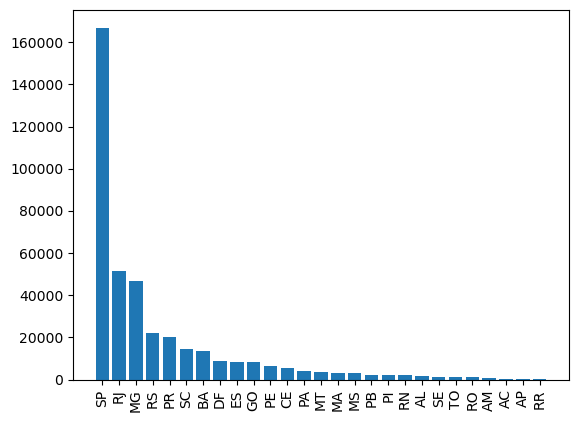

In [34]:
query = """select customer_state,count(customer_id) from customers
group by customer_state"""

cur.execute(query)
data = cur.fetchall()
print(data)
df = pd.DataFrame(data,columns = ["state","customer_count"])
df = df.sort_values(by = "customer_count",ascending = False)
plt.bar(df["state"],df["customer_count"])

plt.xticks(rotation = 90)
plt.show()

# Calculate Number of orders per month in 2018

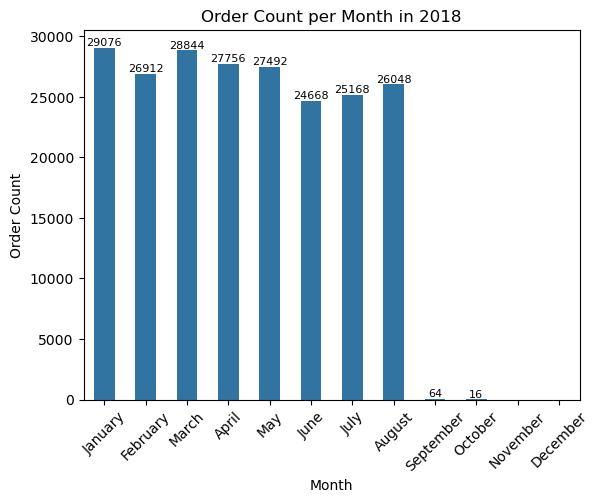

In [109]:
import seaborn as sns

db.rollback()
query = """SELECT EXTRACT(MONTH FROM order_purchase_timestamp::timestamp) AS month_number,
       TO_CHAR(order_purchase_timestamp::timestamp, 'FMMonth') AS month_name,
       COUNT(order_id)
FROM orders
WHERE EXTRACT(YEAR FROM order_purchase_timestamp::timestamp) = 2018
GROUP BY month_number, month_name
ORDER BY month_number;
"""


cur.execute(query)
data = cur.fetchall()


df = pd.DataFrame(data, columns=["month_number", "month_name", "order_count"])


o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]


ax = sns.barplot(x=df['month_number'], y=df['order_count'], order=range(1, 13),width = 0.5) 
ax.bar_label(ax.containers[0],fontsize=8)
plt.xticks(ticks=range(12), labels=o, rotation=45)
plt.xlabel("Month")
plt.ylabel("Order Count")
plt.title("Order Count per Month in 2018")
plt.show()



# Find the average number of products per order,grouped by customer city

In [20]:
db.rollback()
query = """WITH count_per_order AS (
              SELECT orders.order_id,
                     orders.customer_id,
                     COUNT(order_items.order_id) AS oc
              FROM orders
              JOIN order_items ON orders.order_id = order_items.order_id
              GROUP BY orders.order_id, orders.customer_id
          )
          SELECT customers.customer_city,
                 ROUND(AVG(count_per_order.oc), 2) AS average_orders
          FROM customers
          JOIN count_per_order ON customers.customer_id = count_per_order.customer_id
          GROUP BY customers.customer_city;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data).head(15)
df

,0,1
0,bom jardim de minas,16.50
1,alto rio doce,12.00
2,alvorada do gurgueia,12.00
3,batatais,13.29
4,capao da porteira,12.00
5,icatu,12.00
6,osorio,14.06
7,populina,24.00
8,novo mundo,12.00
9,tururu,12.00
